# Forecast a multivariate time series

with TensorFlow 2.0

dataset: Brugge field .mat

## What to implement

각 well마다 104개의 모델이 있다. 이 중에서 80개는 training set으로 나머지는 validation set으로 사용한다.

LSTM은 Input sequence 5개 `(t-5)~(t-1)`, Output sequence 1개`t`로 되어있다. Layer 구성은 2개의 LSTM layer, 2개의 dropout layer, 1개의 Dense layer로 한다. 

Inference시에 
- 먼저 day 1004까지(index 앞의 150개)는 그대로 넣어 predict한다.
- 그 다음부터는 이전 5개의 값으로 t에서의 value를 예측한다.
- 가장 과거의 값(t-5)은 잊어버리고 예측한 값을 window에 넣어준다.
- window 안에 있는 새로운 5개 timestep의 value들의 mean을 구한다.
- 구한 mean과 일정한 std 값으로 Gaussian noise가 들어간 값으로 predict 한 값을 replace한다.
- 즉 window의 가장 최근 값은, predict한 값이 아니라, predict_val + gaussian_noise(window_mean, std)가 들어가게 된다.
- 이 window를 가지고 다음 t에서의 value를 예측한다.

## Setup

In [33]:
import numpy as np
from os.path import dirname, join as pjoin
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

DATA_PATH = '../data'
DATA_FILE_NAME = 'Brugge_en_d.mat'
RESULT_FILE_NAME = 'rmse_brugge.csv'

TRAIN_SPLIT = 150
BUFFER_SIZE = 1000
BATCH_SIZE = 32
EVALUATION_INTERVAL = 10
EPOCHS = 10

NUM_MODEL = 104
TRUE_MODEL = 30
TRAIN_SPLIT = 80
NUM_FEATURES = 4
NUM_FEATURES_USED = 1
INPUT_SEQUENCE = 5
FUTURE_TARGET = 0
STEP = 1

data_dir = pjoin(DATA_PATH, DATA_FILE_NAME)
mat_contents = sio.loadmat(data_dir)

data = mat_contents['en_d'][0, 0]

# tf.debugging.set_log_device_placement(True)

## Data Preparation

In [34]:
well_dic = {}

for well_index in range(20): # well, Producer P1-P20
    # 'model_num' => dataframe
    model_dic = {}
    well_key = 'P' + str(well_index+1)
    for model_index in range(104): # model, model 1-104
        well_data = np.array([
            data['WOPR'][0,0][well_key][:,model_index],
            data['WBHP'][0,0][well_key][:,model_index],
            data['WWCT'][0,0][well_key][:,model_index],
            data['WWPR'][0,0][well_key][:,model_index]
          ])
        # col1: WOPR, col2: WBHP, col3: WWCT, col4: WWPR
        # row1: day1, ... row 498: day3648
        well_data = well_data.T
        df = pd.DataFrame(
            data=well_data,
            columns=['WOPR', 'WBHP', 'WWCT', 'WWPR']
        )
        model_dic[str(model_index+1)] = df
        
    well_dic[str(well_index+1)] = model_dic

In [3]:
def plot_single_well(well_dic, well_num):
    ax = plt.gca()
    true_model_num = 103
    for i in range(104):
        df = well_dic[str(well_num)][str(i+1)]
        if i == true_model_num:
#         if i == 80:
            df.plot(y='WOPR', ax=ax, color='red', legend=False)
#             df.plot(y='WOPR', ax=ax, color='gray', legend=False)
        else:
            df.plot(y='WOPR', ax=ax, color='gray', legend=False)
            
    plt.show()

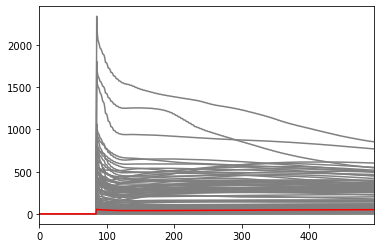

In [4]:
plot_single_well(well_dic, 9)

# Data Preprocessing

In [35]:
well9 = well_dic['9']

In [36]:
# Todo 
# delte rows where WOPR is zero
def remove_zero_wopr(well):
    for model_index in well:
        df = well9[model_index]
        well9[model_index] = df[df.WOPR != 0]

In [37]:
remove_zero_wopr(well9)

In [38]:
def serialize_well_dataframe(well):
    serialized_well = np.empty((0, 4))
    end_indice = []
    for model in well:
        dataset = well[str(model)].values
        serialized_well = np.concatenate((serialized_well, dataset))
        num_timesteps = dataset.shape[0]
        if len(end_indice) == 0:
            end_indice.append(num_timesteps)
        else:
            end_indice.append(num_timesteps + end_indice[-1])
    return serialized_well, end_indice

In [39]:
serialized_dataset, end_indice = serialize_well_dataframe(well9)

In [10]:
serialized_dataset.shape

(42952, 4)

In [ ]:
serialized_dataset[:end_indice[0]]

In [ ]:
serialized_dataset[end_indice[102]:end_indice[103]]

In [40]:
from sklearn.preprocessing import MinMaxScaler

def scale_model_separately(serialized_dataset, end_indice):
    scaler_min = []
    scaler_scale = []
    scaled_dataset = np.empty((0, 4))

    for i in range(len(end_indice)):
        scaler = MinMaxScaler()
        start_index = end_indice[i-1] if i > 0 else 0
        end_index = end_indice[i]
#         print(f"scaling from {start_index} to {end_index-1}")
    
        scaler.fit(serialized_dataset[start_index:end_index])
#         print(f"scaler_min: {scaler.min_[0]}, scaler_scale: {scaler.scale_[0]}")
        
        transformed = scaler.transform(serialized_dataset[start_index:end_index])
        scaled_dataset = np.concatenate((scaled_dataset, transformed))
        scaler_min.append(scaler.min_[0])
        scaler_scale.append(scaler.scale_[0])
        
    return scaled_dataset, scaler_min, scaler_scale

In [41]:
scaled_dataset, scaler_min, scaler_scale = scale_model_separately(serialized_dataset, end_indice)

In [42]:
scaled_dataset.shape

(42952, 4)

In [ ]:
scaled_dataset[:end_indice[0]].shape

In [ ]:
scaled_dataset[:end_indice[0]]

In [ ]:
scaled_dataset[end_indice[100]:end_indice[102]]

In [ ]:
len(scaler_min), len(scaler_scale)

In [43]:
# Todo
# Make multivariate dataset
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
#     print(indices)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
# serialized_train_x = np.empty((0, 5, 2))
# serialized_train_y = np.empty((0))

# past_history = 5
# future_target = 0
# STEP = 1
# train_split = 80
# num_models = 104
# model_list = list(range(1, num_models+1))

# def choose_training_set(scaled_dataset, end_indice):
#     training_set = np.empty((0, 4))
#     train_end_indice = []
#     num_models = 104
#     model_list = list(range(1, num_models+1))
#     train_set_size = 80
#     count = 0
#     while (count < train_set_size): 
#         chosen_model = random.choice(model_list)
#         if (chosen_model != 1) :
#             start_index = end_indice[chosen_model-2]
#             end_index = end_indice[chosen_model-1]
#         else:
#             start_index = 0;
#             end_index = end_indice[chosen_model-1]
#         training_set = np.concatenate((training_set, scaled_dataset[start_index: end_index]))
#         if (count == 0):
#             train_end_indice.append(end_index - start_index)
#         else :
#             train_end_indice.append(train_end_indice[count-1] + (end_index - start_index))
#         count += 1
#     return training_set, train_end_indice

In [44]:
import random
random.seed(2)

def split_train(test_model):
    model_list = list(range(NUM_MODEL))
    train = []
    test = [test_model]
    model_list.remove(test_model)
    for i in range(TRAIN_SPLIT):
        chosen = random.choice(model_list)
        train.append(chosen)
        model_list.remove(chosen)

    val = model_list
    return train, val, test

In [45]:
train_model_list, val_model_list, test_model_list = split_train(test_model=TRUE_MODEL)

In [46]:
def get_dataset(serialized_well, model_list, end_indice):
    dataset_x = np.empty((0, INPUT_SEQUENCE, NUM_FEATURES_USED))
    dataset_y = np.empty((0))

    for i in range(len(model_list)):
        start_index = end_indice[model_list[i]-1] if model_list[i] > 0 else 0 
        end_index = end_indice[model_list[i]]
        range_multi_x, range_multi_y = multivariate_data(
            serialized_well[start_index:end_index][:, :NUM_FEATURES_USED],
            serialized_well[start_index:end_index][:, 0],
            start_index = 0,
            end_index = end_index - start_index,
            history_size = INPUT_SEQUENCE,
            target_size = FUTURE_TARGET,
            step = STEP,
            single_step = True
        )
        dataset_x = np.concatenate((dataset_x, range_multi_x))
        dataset_y = np.concatenate((dataset_y, range_multi_y))

    return dataset_x, dataset_y

In [47]:
train_x, train_y = get_dataset(scaled_dataset, train_model_list, end_indice)
val_x, val_y = get_dataset(scaled_dataset, val_model_list, end_indice)
test_x, test_y = get_dataset(scaled_dataset, test_model_list, end_indice)

In [48]:
train_x.shape, train_y.shape

((32640, 5, 1), (32640,))

In [49]:
val_x.shape, val_y.shape

((9384, 5, 1), (9384,))

In [50]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_data = train_data.prefetch(1)

In [51]:
val_data = tf.data.Dataset.from_tensor_slices((val_x, val_y))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [ ]:
training_set, train_end_indice = choose_training_set(scaled_dataset, end_indice)

In [ ]:
training_set.shape

In [ ]:
for i in range(train_split):
    start_index = end_indice[i-1] if i > 0 else 0
    end_index = end_indice[i]
#     print(f"converting to multivar from {start_index} to {end_index-1}")
    range_multi_x, range_multi_y = multivariate_data(
#         serialized_dataset[start_index:end_index][:, :2],
#         serialized_dataset[start_index:end_index][:, 0],
        training_set[start_index:end_index][:, :2],
        training_set[start_index:end_index][:, 0],
        start_index = 0,
        end_index = end_index - start_index,
        history_size = past_history,
        target_size = future_target,
        step = STEP,
        single_step = True
    )
#     print(range_multi_x.shape)
#     print(range_multi_y.shape)
    serialized_train_x = np.concatenate((serialized_train_x, range_multi_x))
    serialized_train_y = np.concatenate((serialized_train_y, range_multi_y))

In [ ]:
serialized_train_x.shape, serialized_train_y.shape

In [ ]:
#  validate the data set
plt.figure()

plt.scatter(y=serialized_train_x[250:260, 0, 0], x = range(10), label='t-5')
plt.scatter(y=serialized_train_x[250:260, 1, 0], x = range(10), label='t-4')
plt.scatter(y=serialized_train_x[250:260, 2, 0], x = range(10), label='t-3')
plt.scatter(y=serialized_train_x[250:260, 3, 0], x = range(10), label='t-2')
plt.scatter(y=serialized_train_x[250:260, 4, 0], x = range(10), label='t-1')
plt.scatter(y=serialized_train_y[250:260], x=range(10), label='t')

plt.legend()
plt.show()

In [ ]:
serialized_val_x = np.empty((0, 5, 2))
serialized_val_y = np.empty((0))

for i in range(train_split, 103, 1):
    start_index = end_indice[i-1] if i > 0 else 0
    end_index = end_indice[i]
#     print(f"converting to multivar from {start_index} to {end_index-1}")
    range_multi_x, range_multi_y = multivariate_data(
        serialized_dataset[start_index:end_index][:, :2],
        serialized_dataset[start_index:end_index][:, 0],
        start_index = 0,
        end_index = end_index - start_index,
        history_size = past_history,
        target_size = future_target,
        step = STEP,
        single_step = True
    )
#     print(range_multi_x.shape)
#     print(range_multi_y.shape)
    serialized_val_x = np.concatenate((serialized_val_x, range_multi_x))
    serialized_val_y = np.concatenate((serialized_val_y, range_multi_y))

In [ ]:
serialized_val_x.shape, serialized_val_y.shape

In [ ]:
serialized_test_x = np.empty((0, 5, 2))
serialized_test_y = np.empty((0))

for i in range(103, 104):
    start_index = end_indice[i-1] if i > 0 else 0
    end_index = end_indice[i]
    print(f"converting to multivar from {start_index} to {end_index-1}")
    range_multi_x, range_multi_y = multivariate_data(
        serialized_dataset[start_index:end_index][:, :2],
        serialized_dataset[start_index:end_index][:, 0],
        start_index = 0,
        end_index = end_index - start_index,
        history_size = past_history,
        target_size = future_target,
        step = STEP,
        single_step = True
    )
    serialized_test_x = np.concatenate((serialized_test_x, range_multi_x))
    serialized_test_y = np.concatenate((serialized_test_y, range_multi_y))

In [ ]:
serialized_test_x.shape, serialized_test_y.shape

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((serialized_train_x, serialized_train_y))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_data = train_data.prefetch(1)

val_data = tf.data.Dataset.from_tensor_slices((serialized_val_x, serialized_val_y))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((serialized_test_x, serialized_test_y))

# Define model and Train

In [52]:
lstm1_units = 50
lstm2_units = 50
gaussian_std = 0.1
dropout_rate = 0.2

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.GaussianNoise(gaussian_std, input_shape=train_x.shape[-2:]))

single_step_model.add(tf.keras.layers.LSTM(lstm1_units, activation='relu',return_sequences=True))
single_step_model.add(tf.keras.layers.Dropout(dropout_rate))

single_step_model.add(tf.keras.layers.LSTM(lstm2_units, activation='relu', return_sequences = True))
single_step_model.add(tf.keras.layers.Dropout(dropout_rate))

single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer='adam', loss='mean_squared_error')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=1)

In [53]:
single_step_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 5, 1)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 50)             10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5, 1)              51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
__________________________________________________

In [54]:
for x, y in val_data.take(1):
  print(single_step_model.predict(x).shape)

(32, 5, 1)


In [55]:
single_step_history = single_step_model.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=train_y.shape[0]//BATCH_SIZE,
    validation_data=val_data,
    validation_steps=val_y.shape[0]//BATCH_SIZE,
    use_multiprocessing=True,
    workers=8,
    callbacks = [es]
)

Train for 1020 steps, validate for 293 steps
Epoch 1/10
1020/1020 [==============================] - 22s 22ms/step - loss: 0.0187 - val_loss: 0.0050
Epoch 2/10
1020/1020 [==============================] - 17s 17ms/step - loss: 0.0053 - val_loss: 0.0041
Epoch 3/10
1020/1020 [==============================] - 16s 15ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 4/10
1020/1020 [==============================] - 16s 16ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 5/10
1020/1020 [==============================] - 16s 15ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 6/10
1020/1020 [==============================] - 16s 15ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 7/10
1020/1020 [==============================] - 16s 16ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 8/10
1020/1020 [==============================] - 16s 16ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 9/10
1020/1020 [==============================] - 18s 18ms/step - loss: 0.0045 - val_loss: 0.0049
Epoch 10/10
1020/10

In [56]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

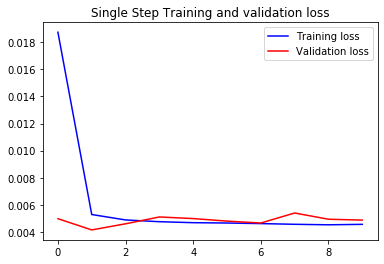

In [57]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

# Inference

In [63]:
def cascade_inference(model, test_x, test_y, obs):
    y_hat_list = []
    observed = test_y[:obs]
    y_hat_list.extend(observed)

    buffer = test_x[obs:obs+1]
    mu = 0.1

    for i in range(obs+1, test_x.shape[0]):
        y_hat = model.predict(buffer)
        predicted_val = y_hat[0, 0, 0]
        y_hat_list.append(predicted_val)
    
        buffer = np.delete(buffer, 0, 1)
#         next_wbhp = test_x[i:i+1][0, 4, 1]
        predicted_array = np.array([[predicted_val]])
    
        buffer = np.vstack((buffer[0], predicted_array))
        buffer = np.reshape(buffer, (1, 5, 1))
    
        mean_wopr = np.mean(buffer[0], axis=0)[0]
#         mean_wbhp = np.mean(buffer[0], axis=0)[1]
        wopr_predicted_noise_added = np.random.normal(mean_wopr, mu, 1)
#         wbhp_predicted_noise_added = np.random.normal(mean_wbhp, mu, 1)
    
        buffer[0, 4, 0] = wopr_predicted_noise_added
#         buffer[0, 4, 1] = wbhp_predicted_noise_added

    return y_hat_list

In [64]:
OBSERVATION_DATE = 150
y_hat_list = cascade_inference(single_step_model, test_x, test_y, obs=OBSERVATION_DATE)

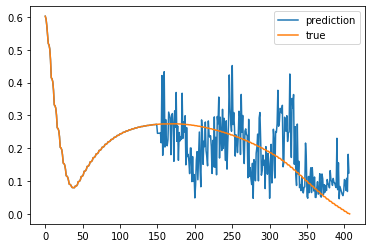

In [65]:
plt.plot(y_hat_list, label='prediction')
plt.plot(test_y, label='true')

plt.legend()
plt.show()

In [ ]:
y_hat_list = []
predicted_differences = []

y_hat = single_step_model.predict(serialized_test_x[:150])
y_hat_list = y_hat[:, -1].flatten().tolist()
print(len(y_hat_list))
buffer_test_x = serialized_test_x[150:151]
print(f"before loop {buffer_test_x}, shape {buffer_test_x.shape}")

mu = 0.01
buffer = buffer_test_x

In [ ]:
for i in range(151, serialized_test_x.shape[0]):
# for i in range(1, 11):
    y_hat = single_step_model.predict(buffer)
#     print(f"y_hat: {y_hat}, shape: {y_hat.shape}")
    predicted_val = y_hat[0, 0, 0]
    y_hat_list.append(predicted_val)
    
    difference = serialized_test_x[i:i+1][0, 4, 0] - predicted_val
    predicted_differences.append(difference)
    
    buffer = np.delete(buffer, 0, 1)
    next_wbhp = serialized_test_x[i:i+1][0, 4, 1]
    predicted_array = np.array([[predicted_val, next_wbhp]])
    
    buffer = np.vstack((buffer[0], predicted_array))
    buffer = np.reshape(buffer, (1, 5, 2))
    
    mean_wopr = np.mean(buffer[0], axis=0)[0]
    mean_wbhp = np.mean(buffer[0], axis=0)[1]
    wopr_predicted_noise_added = np.random.normal(mean_wopr, mu, 1)
    wbhp_predicted_noise_added = np.random.normal(mean_wbhp, mu, 1)
    
    buffer[0, 4, 0] = wopr_predicted_noise_added
    buffer[0, 4, 1] = wbhp_predicted_noise_added
    
#     buffer = np.concatenate((wopr_noise, wbhp_noise), axis = 1)
#     buffer = np.reshape(buffer, (1, 5, 2))
#     print(f"after insertion {buffer}, shape: {buffer.shape}")

In [ ]:
print(len(y_hat_list))
print(serialized_test_y.shape)

plt.plot(y_hat_list, label='prediction')
plt.plot(serialized_test_y, label='true')
# plt.scatter(y=y_hat_list, x = range(len(y_hat_list)), label='prediction')
# plt.scatter(y=serialized_test_y, x = range(len(serialized_test_y)), label='true')

plt.legend()
plt.show()

In [ ]:
print(len(predicted_differences))
plt.plot(predicted_differences, label = 'differences')
plt.legend()
plt.show()

In [ ]:
y_hat = single_step_model.predict(serialized_test_x)
# print(y_hat.shape)
print(y_hat[:,-1].shape)
print(serialized_test_y.shape)
# print(y_train_single.shape)
plt.plot(y_hat[:,-1], label='prediction')
plt.plot(serialized_test_y, label='true')
# plt.plot(dataset[TRAIN_SPLIT:][:,0], label='from_dataset')
plt.legend()
plt.show()

In [ ]:
serialized_test_x[1:2][0]

In [ ]:
y_hat

In [ ]:
# Todo
# Temp plotting
# predict from training set
x_entire, _ = multivariate_data(dataset[:, :2], dataset[:, 0], 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

y_hat = single_step_model.predict(x_entire)
# print(y_hat[:,-1].shape)
# print(y_train_single.shape)
plt.plot(y_hat[:,-1], label='prediction')
plt.plot(dataset[:, 0], label='true')
plt.legend()
plt.show()

In [ ]:
y_hat = single_step_model.predict(x_val_single)
# print(y_hat.shape)
print(y_hat[:,-1].shape)
print(y_val_single.shape)
# print(y_train_single.shape)
plt.plot(y_hat[:,-1], label='prediction')
plt.plot(y_val_single, label='true')
# plt.plot(dataset[TRAIN_SPLIT:][:,0], label='from_dataset')
plt.legend()
plt.show()

In [ ]:
scaler.min_

In [ ]:
scaler.scale_

In [ ]:
# Evalutate RMSE first and inverse trnasform
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(y_val_single, y_hat[:, -1]))
print('Test RMSE: %.3f' % rmse)

# mse = mean_squared_error(y_val_single, y_hat[:, -1])
# print('Test RMSE: %.3f' % mse)

In [ ]:
# single_feature_inverse = (y_hat[:, -1] - scaler.min_[0])/scaler.scale_[0]

In [ ]:
y_hat_inverse = (y_hat[:, -1] - scaler.min_[0])/scaler.scale_[0]
y_val_inverse = (y_val_single - scaler.min_[0])/scaler.scale_[0]
y_train_inverse = (y_train_single - scaler.min_[0])/scaler.scale_[0]

y_train_inverse = y_train_inverse.reshape((-1, 1))
y_predicted = np.concatenate((y_train_inverse, y_hat_inverse), axis = None)
y_true = np.concatenate((y_train_inverse, y_val_inverse.reshape((-1, 1))), axis = None)

In [ ]:
plt.plot(y_predicted, linestyle='-', label='prediction')
plt.plot(y_true, linestyle='-', label='true')
plt.xlabel('date')
plt.ylabel('WOPR')
plt.title('WOPR true vs prediction')
plt.legend()
plt.show()

In [ ]:
# Using StandardScaler
# y_hat_inverse = y_hat[:,-1] * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
# y_val_inverse = y_val_single * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
# y_train_inverse = y_train_single * np.sqrt(scaler.var_[0]) + scaler.mean_[0]

# y_train_inverse = y_train_inverse.reshape((-1, 1))
# y_predicted = np.concatenate((y_train_inverse, y_hat_inverse), axis = None)
# y_true = np.concatenate((y_train_inverse, y_val_inverse.reshape((-1, 1))), axis = None)

# plt.plot(y_predicted, linestyle='-', label='prediction')
# plt.plot(y_true, linestyle='-', label='true')
# plt.xlabel('date')
# plt.ylabel('WOPR')
# plt.title('WOPR true vs prediction')
# plt.legend()
# plt.show()

# Evaluate the model

In [ ]:
# y_hat_inverse = y_hat[:,-1] * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
# y_val_inverse = y_val_single * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
# print(y_hat_inverse.shape)
# print(y_val_inverse.reshape((-1, 1)).shape)

In [ ]:
# calculate RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error

# rmse = sqrt(mean_squared_error(y_val_inverse, y_hat_inverse))
# print('Test RMSE: %.3f' % rmse)

mse = mean_squared_error(y_val_inverse, y_hat_inverse)
print('Test RMSE: %.3f' % mse)

In [ ]:
result_dir = pjoin(DATA_PATH, RESULT_FILE_NAME)

with open(result_dir, "a") as f:
    f.write(f"{well_index}, {model_index}, {rmse}, {BATCH_SIZE}, {EPOCHS}, {TRAIN_SPLIT}, {past_history}, {future_target}, {lstm1_units}, {lstm2_units}, {gaussian_std}, {dropout_rate}")
    f.close()

In [ ]:
tf.keras.backend.clear_session()